<a href="https://colab.research.google.com/github/asangphukieo/NGS_workshop/blob/main/Day5/Notebook/01_circos_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization genetic variants by Circos plot

In [1]:
# Install pycirclize in python
%pip install pycirclize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.9 MB/s eta 0:00:00


## 1. Download input data
1. Single nucleotile variant (SNV):
2. Structural variant (SV):

In [2]:
!wget https://raw.githubusercontent.com/asangphukieo/NGS_workshop_2024/main/Day5/Input_Circos/01_gatk_somatic_pass.vcf
!wget https://raw.githubusercontent.com/asangphukieo/NGS_workshop_2024/main/Day5/Input_Circos/02_somaticSV.bedpe

--2024-02-04 14:48:11--  https://raw.githubusercontent.com/asangphukieo/NGS_workshop_2024/main/Day5/Input_Circos/01_gatk_somatic_pass.vcf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274295 (268K) [text/plain]
Saving to: ‘01_gatk_somatic_pass.vcf’

01_gatk_somatic_pas 100%[===================>] 267.87K  --.-KB/s    in 0.03s   

2024-02-04 14:48:11 (8.12 MB/s) - ‘01_gatk_somatic_pass.vcf’ saved [274295/274295]

--2024-02-04 14:48:11--  https://raw.githubusercontent.com/asangphukieo/NGS_workshop_2024/main/Day5/Input_Circos/02_somaticSV.bedpe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

## 2. Open Python console and import required packages

In [17]:
# Import required packages
from pycirclize import Circos
from pycirclize.utils import ColorCycler
from pycirclize.utils import load_eukaryote_example_dataset
import numpy as np
import pandas as pd
import gzip
np.random.seed(0)

## 3. Create function to read VCF input files

In [4]:
# 3.1 create function to read vcf file
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x.replace("\n","").replace("#","") for x in line.split('\t')]
                  break
    ifile.close()
    return vcf_names


In [5]:
# 3.2 import SNV file and create dictionary
names = get_vcf_names('01_gatk_somatic_pass.vcf')
vcf = pd.read_csv('01_gatk_somatic_pass.vcf',  comment='#', delim_whitespace=True, header=None, names=names)
snv_dict={}
for i in range(1,23):
  #print(i)
  snv_dict["chr"+str(i)] = list(vcf[vcf.CHROM == "chr"+str(i)].POS)
snv_dict["chrX"] = list(vcf[vcf.CHROM == "chrX"].POS)

In [6]:
vcf.head

<bound method NDFrame.head of     CHROM        POS ID  REF ALT QUAL FILTER  \
0    chr1     881924  .   CC  GT    .   PASS   
1    chr1    1785103  .  CTT   C    .   PASS   
2    chr1    2654659  .    G   A    .   PASS   
3    chr1    2654664  .    T   C    .   PASS   
4    chr1    8245627  .    A   C    .   PASS   
..    ...        ... ..  ...  ..  ...    ...   
919  chrX  135669123  .    C   G    .   PASS   
920  chrX  136497472  .    A   G    .   PASS   
921  chrX  139479474  .  CAA   C    .   PASS   
922  chrX  151599704  .    A   C    .   PASS   
923  chrX  155887937  .  CAA   C    .   PASS   

                                                  INFO  \
0    AS_FilterStatus=SITE;AS_SB_TABLE=29,19|3,2;DP=...   
1    AS_FilterStatus=SITE;AS_SB_TABLE=12,23|0,3;DP=...   
2    AS_FilterStatus=SITE;AS_SB_TABLE=32,26|1,3;DP=...   
3    AS_FilterStatus=SITE;AS_SB_TABLE=29,25|1,3;DP=...   
4    AS_FilterStatus=SITE;AS_SB_TABLE=16,6|0,4;DP=2...   
..                                           

In [11]:
# show first 10 position of CHR2
snv_dict["chr2"][1:10]

[29548472,
 33757347,
 35087888,
 37106568,
 38828722,
 40258930,
 40432423,
 48521344,
 50976194]

## 4. Create function to read SV input files

In [12]:
# 4.1 create function to read SV file
def get_SV_names(sv_path):
    with open(sv_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  sv_names = [x.replace("\n","").replace("#","") for x in line.split('\t')]
                  break
    ifile.close()
    return sv_names



In [13]:
# 4.2 import SV file and create dictionary
svnames = get_SV_names('02_somaticSV.bedpe')
sv = pd.read_csv('02_somaticSV.bedpe', comment='#', delim_whitespace=True, header=None, names=svnames)
sv = sv[sv.FILTER == "PASS" ]

sv_dict={}
for i in range(1,23):
  #print(i)
  sv_dict["chr"+str(i)] = sv[sv.CHROM_A == "chr"+str(i)]
sv_dict["chrX"] = sv[sv.CHROM_A == "chrX"]

## 5. Load cytoband of hg38 reference

In [18]:
# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")


In [45]:
# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color dict
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

## 6. Adding tracks of Circos plot

In [31]:
# Plot chromosome name & xticks
for sector in circos.sectors:
  print(sector)

# Sector = 'chr1'
# Size = 248956422 (0 - 248956422)
# Degree Size = 23.22 (0.00 - 23.22)
# Track List = ['cytoband']

# Sector = 'chr2'
# Size = 242193529 (0 - 242193529)
# Degree Size = 22.59 (26.22 - 48.80)
# Track List = ['cytoband']

# Sector = 'chr3'
# Size = 198295559 (0 - 198295559)
# Degree Size = 18.49 (51.80 - 70.29)
# Track List = ['cytoband']

# Sector = 'chr4'
# Size = 190214555 (0 - 190214555)
# Degree Size = 17.74 (73.29 - 91.03)
# Track List = ['cytoband']

# Sector = 'chr5'
# Size = 181538259 (0 - 181538259)
# Degree Size = 16.93 (94.03 - 110.96)
# Track List = ['cytoband']

# Sector = 'chr6'
# Size = 170805979 (0 - 170805979)
# Degree Size = 15.93 (113.96 - 129.89)
# Track List = ['cytoband']

# Sector = 'chr7'
# Size = 159345973 (0 - 159345973)
# Degree Size = 14.86 (132.89 - 147.75)
# Track List = ['cytoband']

# Sector = 'chr8'
# Size = 145138636 (0 - 145138636)
# Degree Size = 13.54 (150.75 - 164.29)
# Track List = ['cytoband']

# Sector = 'chr9'
# Size = 1383947

In [37]:
# 1. Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb")

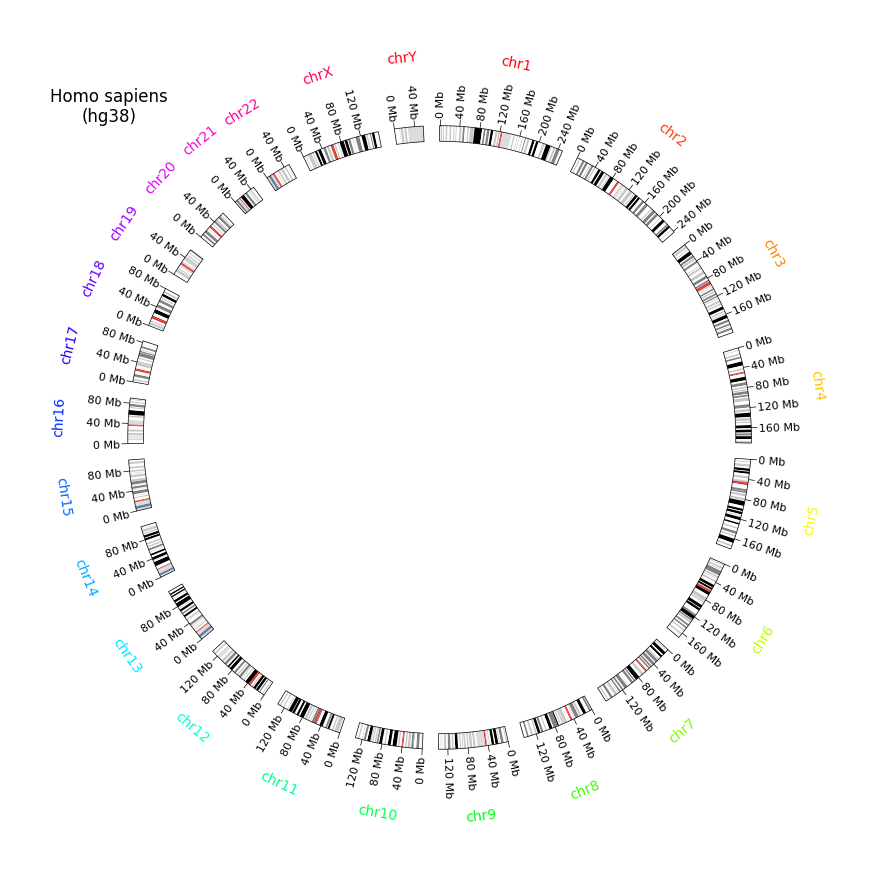

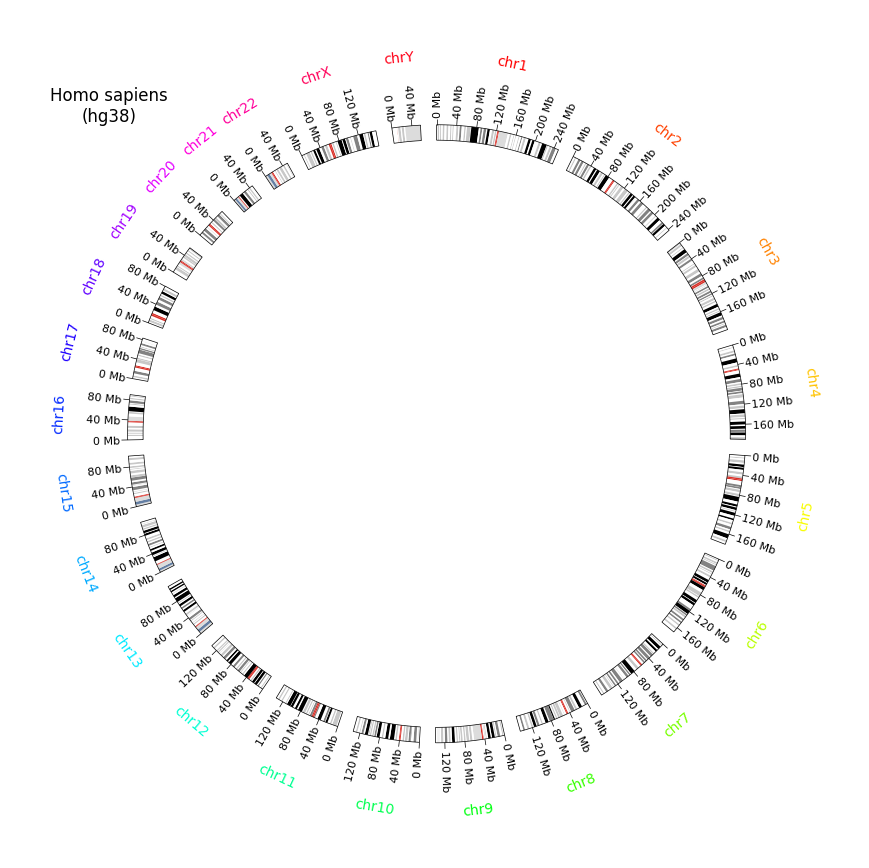

In [38]:
circos.plotfig()

In [42]:
# 2. Add SNPs in scatter track

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color dict
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}


# Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb")

    if sector.name in snv_dict:
      x = snv_dict[sector.name]
      y = np.random.randint(0, 100, size=len(x))
      # Scatter track
      track1 = sector.add_track((85, 95), r_pad_ratio=0.1)
      track1.axis()
      track1.scatter(x, y, s=6, color="red")


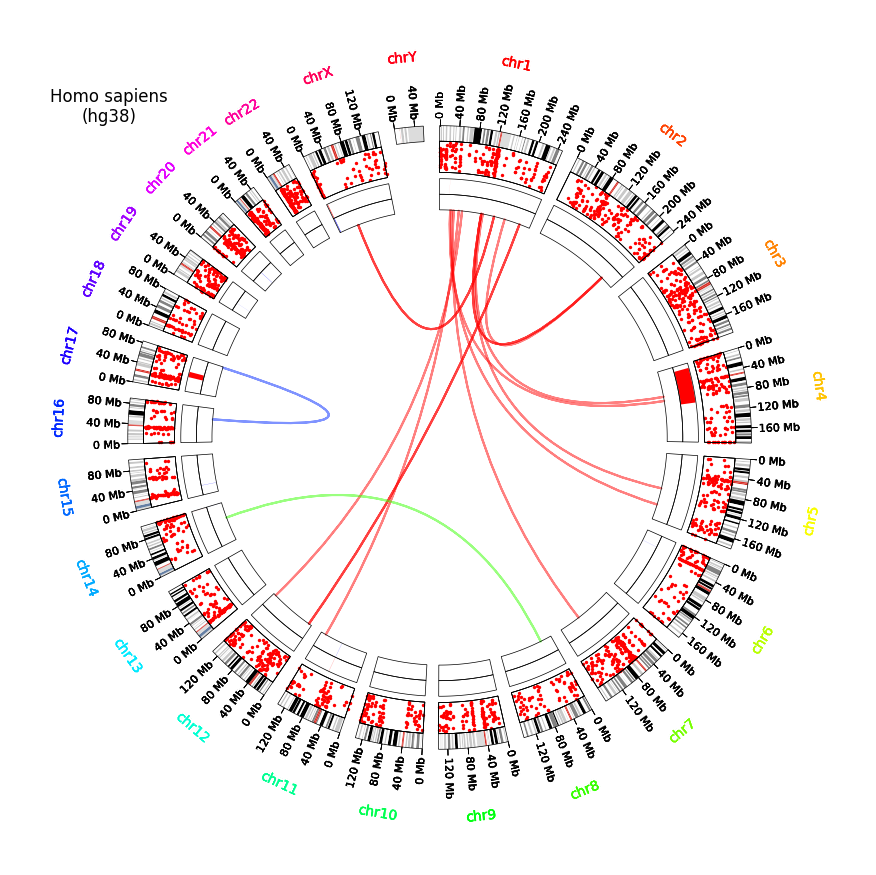

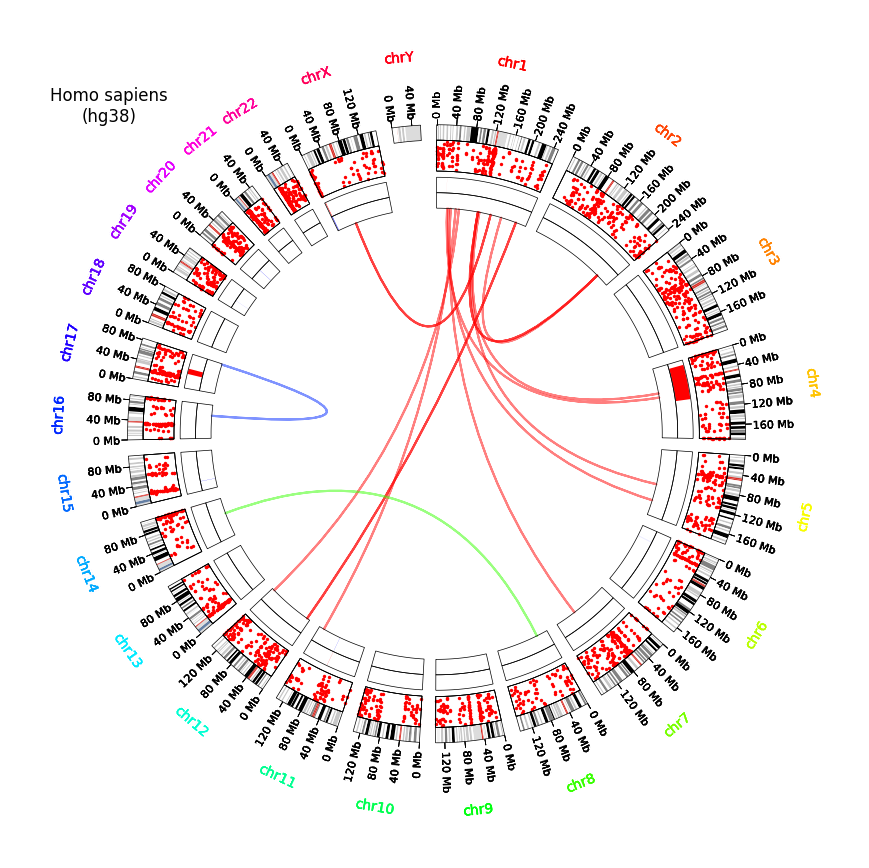

In [44]:
circos.plotfig()

In [47]:
# 3. Add SVs in bar track

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color dict
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

###############################
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb")

    if sector.name in snv_dict:
      x = snv_dict[sector.name]
      y = np.random.randint(0, 100, size=len(x))
      # Scatter track
      track1 = sector.add_track((85, 95), r_pad_ratio=0.1)
      track1.axis()
      track1.scatter(x, y, s=6, color="red")

    # Deletion
    if sector.name in sv_dict:
      del_list = sv_dict[sector.name][sv_dict[sector.name].TYPE=="DEL"]
      del_track = sector.add_track((78, 83), r_pad_ratio=0.05)
      del_track.axis()
      for i in range(0, len(del_list)):
        del_track.rect(start=del_list.iloc[i]['START_A'], end=del_list.iloc[i]['END_B'], color="red")

    # Duplication
    if sector.name in sv_dict:
      dup_list = sv_dict[sector.name][sv_dict[sector.name].TYPE=="DUP"]
      dup_track = sector.add_track((73, 78), r_pad_ratio=0.05)
      dup_track.axis()
      for i in range(0, len(dup_list)):
        dup_track.rect(start=dup_list.iloc[i]['START_A'], end=dup_list.iloc[i]['END_B'], color="blue")

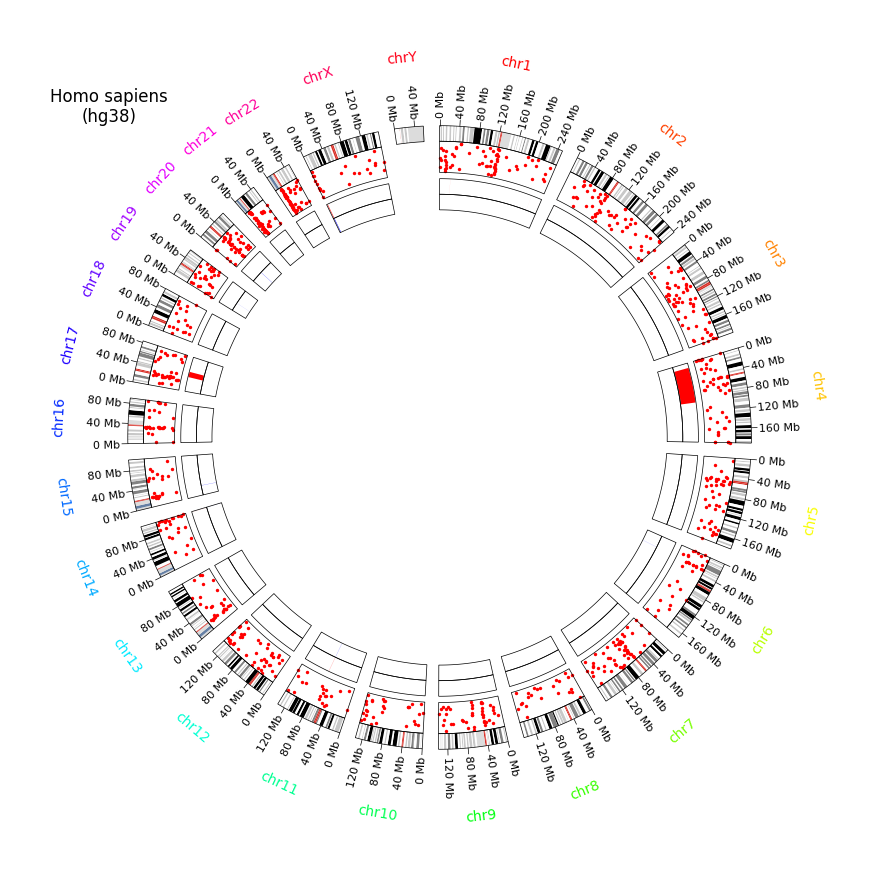

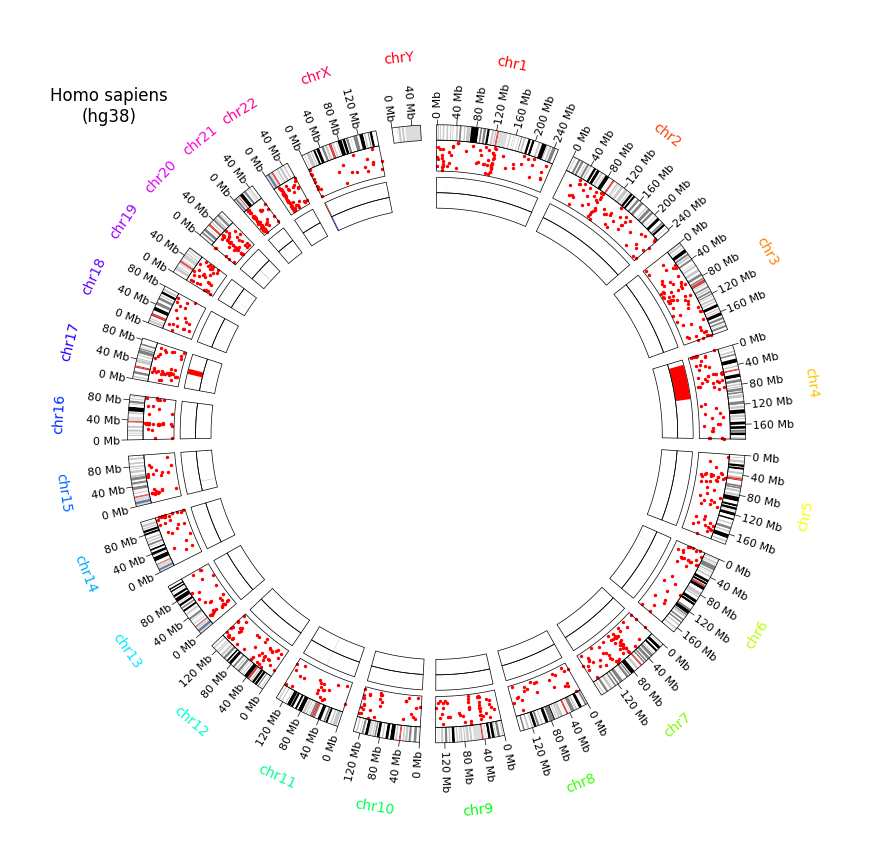

In [48]:
circos.plotfig()

In [49]:
# 4. Add translocation track

# Plot chromosome link
BND_list = sv[sv.TYPE=="BND"]
for i in range(0, len(BND_list)):
    region1 = (BND_list.iloc[i]['CHROM_A'], BND_list.iloc[i]['START_A'], BND_list.iloc[i]['END_A'])
    region2 = (BND_list.iloc[i]['CHROM_B'], BND_list.iloc[i]['START_B'], BND_list.iloc[i]['END_B'])
    color = chr_name2color[BND_list.iloc[i]['CHROM_A']]
    if BND_list.iloc[i]['CHROM_A'] in ("chr1", "chr8", "chr16") and BND_list.iloc[i]['CHROM_A'] != BND_list.iloc[i]['CHROM_B']:
        circos.link(region1, region2, color=color,lw=1.5)


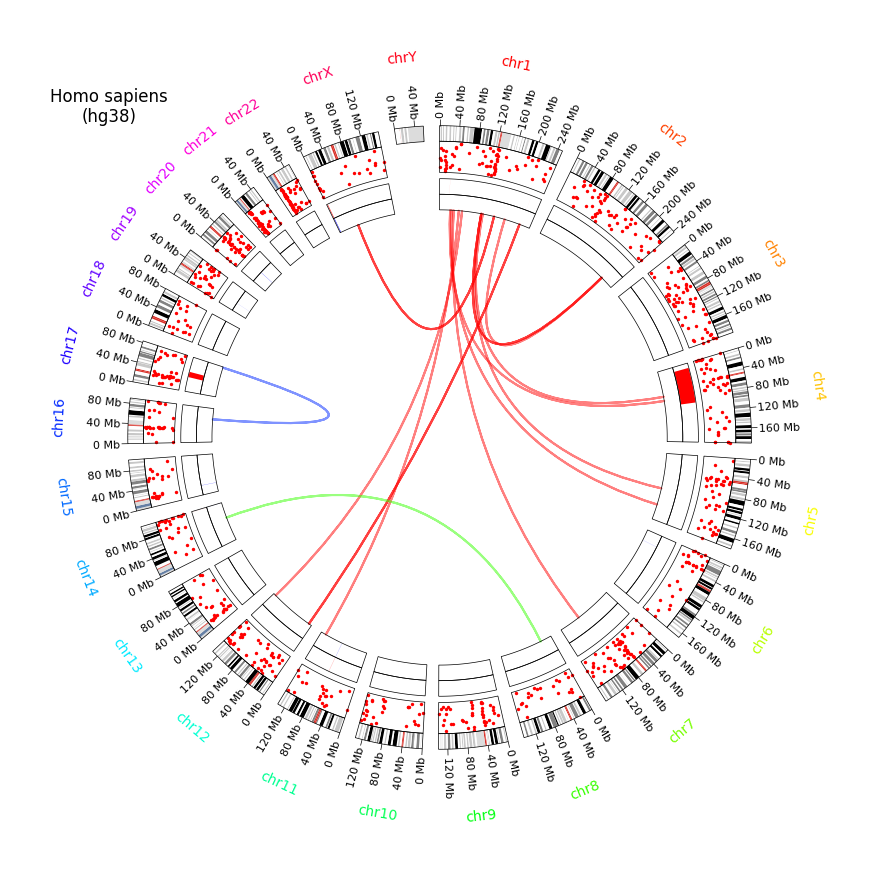

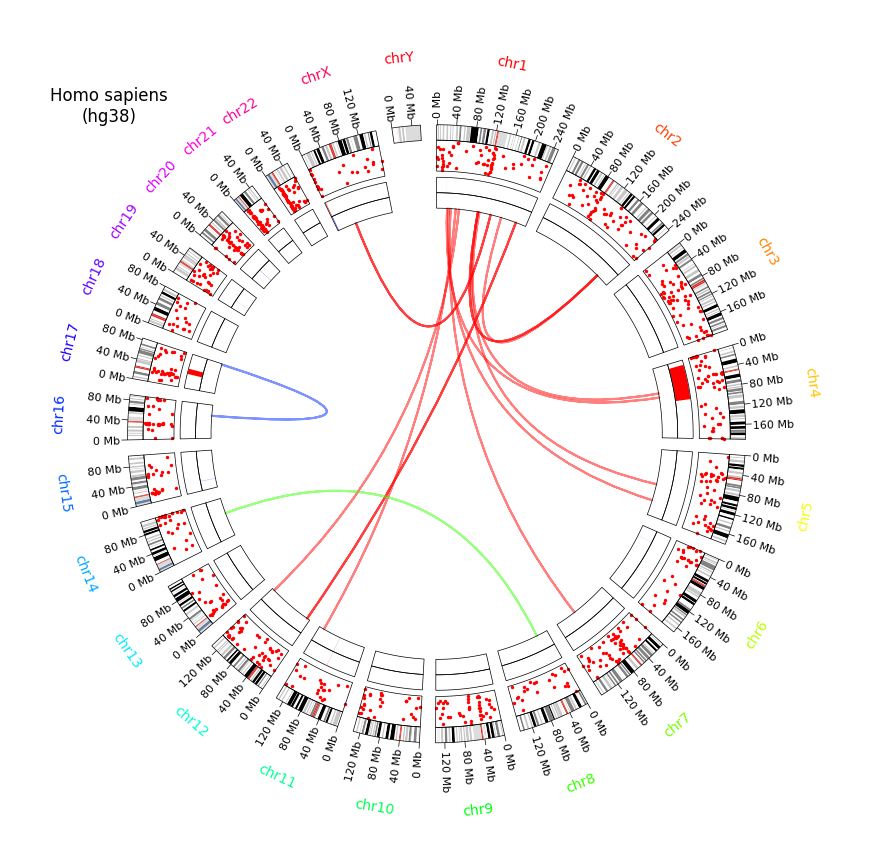

In [50]:
circos.plotfig()

## 7. Run full script

In [51]:
# Full script
# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color dict
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

###############################
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb")

    if sector.name in snv_dict:
      x = snv_dict[sector.name]
      y = np.random.randint(0, 100, size=len(x))
      # Scatter track
      track1 = sector.add_track((85, 95), r_pad_ratio=0.1)
      track1.axis()
      track1.scatter(x, y, s=6, color="red")

    # Deletion
    if sector.name in sv_dict:
      del_list = sv_dict[sector.name][sv_dict[sector.name].TYPE=="DEL"]
      del_track = sector.add_track((78, 83), r_pad_ratio=0.05)
      del_track.axis()
      for i in range(0, len(del_list)):
        del_track.rect(start=del_list.iloc[i]['START_A'], end=del_list.iloc[i]['END_B'], color="red")

    # Duplication
    if sector.name in sv_dict:
      dup_list = sv_dict[sector.name][sv_dict[sector.name].TYPE=="DUP"]
      dup_track = sector.add_track((73, 78), r_pad_ratio=0.05)
      dup_track.axis()
      for i in range(0, len(dup_list)):
        dup_track.rect(start=dup_list.iloc[i]['START_A'], end=dup_list.iloc[i]['END_B'], color="blue")

# Plot chromosome link
BND_list = sv[sv.TYPE=="BND"]
for i in range(0, len(BND_list)):
    region1 = (BND_list.iloc[i]['CHROM_A'], BND_list.iloc[i]['START_A'], BND_list.iloc[i]['END_A'])
    region2 = (BND_list.iloc[i]['CHROM_B'], BND_list.iloc[i]['START_B'], BND_list.iloc[i]['END_B'])
    color = chr_name2color[BND_list.iloc[i]['CHROM_A']]
    if BND_list.iloc[i]['CHROM_A'] in ("chr1", "chr8", "chr16") and BND_list.iloc[i]['CHROM_A'] != BND_list.iloc[i]['CHROM_B']:
        circos.link(region1, region2, color=color,lw=1.5)

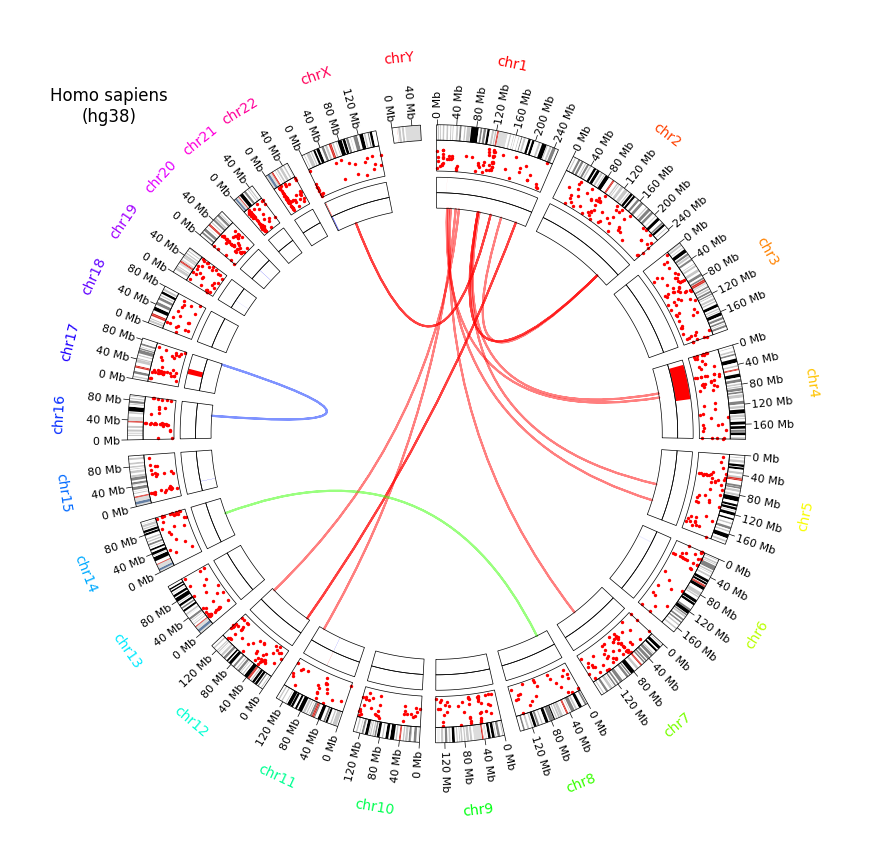

In [55]:
fig = circos.plotfig()
fig.savefig("circos_ouput.png", dpi=300)